<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#In-This-Notebook" data-toc-modified-id="In-This-Notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>In This Notebook</a></span></li><li><span><a href="#Persons" data-toc-modified-id="Persons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Persons</a></span><ul class="toc-item"><li><span><a href="#Data-pickle" data-toc-modified-id="Data-pickle-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data pickle</a></span></li><li><span><a href="#person-bboxer-(3-bboxes-max)" data-toc-modified-id="person-bboxer-(3-bboxes-max)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><code>person</code> bboxer (3 bboxes max)</a></span></li></ul></li></ul></div>

# In This Notebook

**Context**

This notebook will take the single labeled bbox code and attempt multiple bounding boxes. I'll start with doing it just for one class (persons), then for persons and barn animals.

**To do:**
* 2020-10-21: use a Transform pad bboxes and lbls with zeros for n_obj < max_obj

**Log**

- 2020-10-20 (Tuesday): Created nb. Created pickle for persons and barn animals.
- 2020-10-21 (Wednesday): Completed persons ETL; ready for dss and dls. Started learning about loss function for SSD. Left off https://www.youtube.com/watch?v=0frKXR-2PBY at 1:24:55.
- 2020-10-22 (Thursday): Person detector (0-3 instances) working.
- 2020-10-26 (Monday): Cleaned up person bboxer and started on pets bboxer. Pets bboxer is learning, but not what it should be. I may want to start the SSD method tomorrow b/c I do not think this approach will work well or scale up.
- 2020-10-27 (Tuesday):
    - Renamed from _20201020_coco_multiple_bboxes.ipynb to _20201020_coco_multiple_bboxes_persons.ipynb.
    - Copied nb to hold Pets work; renamed _20201027_coco_multiple_bboxes_pets.ipynb

**Thoughts/Notes:**
- 2020-10-21 (Wed): I should remove images from the dataset that are tricky:
    - 90% background with only tiny people
    - humans in advertisements
    - images with buses (seems to be lots of mistakes)
    - images with partial humans (e.g., hands showing only)
- 2020-10-22 (Thu): I will attempt the problem without using the SSD technique. (Got it working!).
- 2020-10-26 (Mon):
    - I ordered bbox inputs (p1,p2,p3,c1,c2,c3,d1,d2,d3) s.t. p1 is larger than p2 and p2 is larger than p3. This does not appear to have worked, even with the pets dataset I created.
    - Person bboxer's dls.train.n → 15701. Pet bboxer's dls.train.n → 6778. Harder task + fewer training samples = worse results. However, the learner doesn't appear to be learning the task at all. The results do not make sense.

# Persons

## Data pickle

In [ ]:
from fastai.vision.all import *

### 40sec ###


### Get files and annos ###
# paths to data
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'
# create lists of items
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path, train_json, train_im_dir)
valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]
# create helper cols
is_valid = [0]*len(train_files) + [1]*len(valid_files)
n_items  = L(len(l) for l in lbls)


### Create subsets for task ###
def transpose(anno): return list(zip(*anno)) # tensor.t()
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos  = L(sort_annos(i) for i in annos)
sorted_bboxes = L(L(o[0] for o in a) for a in sorted_annos)
sorted_lbls   = L(L(o[1] for o in a) for a in sorted_annos)

# persons
person_idxs   = L(L(o=='person' for o in lbl) for lbl in sorted_lbls)
person_lbls   = L(o[i] for o,i in zip(sorted_lbls,  person_idxs))
person_bboxes = L(o[i] for o,i in zip(sorted_bboxes,person_idxs))

# pets
pets_subset  = ['person','cat','dog']
pets_idxs    = L(L(o in pets_subset for o in lbl) for lbl in sorted_lbls)
pets_lbls    = L(o[i] for o,i in zip(sorted_lbls,  pets_idxs))
pets_bboxes  = L(o[i] for o,i in zip(sorted_bboxes,pets_idxs))
n_pets_items = L(len(l) for l in pets_lbls)

# barn
barn_subset  = ['person','cat','dog','cow','sheep','horse']
barn_idxs    = L(L(o in barn_subset for o in lbl) for lbl in sorted_lbls)
barn_lbls    = L(o[i] for o,i in zip(sorted_lbls,  barn_idxs))
barn_bboxes  = L(o[i] for o,i in zip(sorted_bboxes,barn_idxs))
n_barn_items = L(len(l) for l in barn_lbls)

# count instances of each class
def count_instances(lbl, lol): return L(sum([o==lbl for o in l]) for l in lol)
n_persons = count_instances('person', sorted_lbls)
n_cats    = count_instances('cat', sorted_lbls)
n_dogs    = count_instances('dog', sorted_lbls)
n_cows    = count_instances('cow', sorted_lbls)
n_sheep   = count_instances('sheep', sorted_lbls)
n_horses  = count_instances('horses', sorted_lbls)


### Store outputs in a pickle ###
df = pd.DataFrame({
    # basics
    "path": files,
    "lbl":  sorted_lbls,
    "bbox": sorted_bboxes,
    "is_valid": is_valid,
    "n_items": n_items,
    # persons
    "person_lbls": person_lbls,
    "person_bboxes": person_bboxes,
    "n_persons": n_persons,
    # pets
    "pets_lbls": pets_lbls,
    "pets_bboxes": pets_bboxes,
    "n_pets_items": n_pets_items,
    "n_cats": n_cats,
    "n_dogs": n_dogs,
    # barn
    "barn_lbls": barn_lbls,
    "barn_bboxes": barn_bboxes,
    "n_barn_items": n_barn_items,
    "n_cows": n_cows,
    "n_sheep": n_sheep,
    "n_horses": n_horses
    })
df.to_pickle(path/'20201020_coco_multiple_bboxes_df.pkl')

## `person` bboxer (3 bboxes max)

In [ ]:
### Unused Helpers ###
# flatten L or list
def flatten(l):
    def _recur(l,res):
        for o in l:
            if   isinstance(o,L)   : _recur(o,res)
            elif isinstance(o,list): _recur(o,res)
            else: res.append(o)
        return res
    return _recur(l,L())    

lr_min: 0.0019054606556892395


epoch,train_loss,valid_loss,time
0,0.455009,0.202727,00:34
1,0.162561,0.115428,00:34
2,0.127478,0.123175,00:34
3,0.118684,0.110030,00:34
4,0.106014,0.111867,00:34
5,0.089044,0.097221,00:34
6,0.070447,0.091321,00:35
7,0.053874,0.087808,00:34
8,0.040647,0.086992,00:35
9,0.035938,0.087814,00:34


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

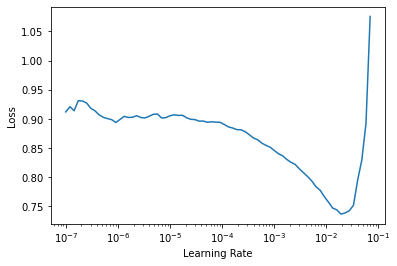

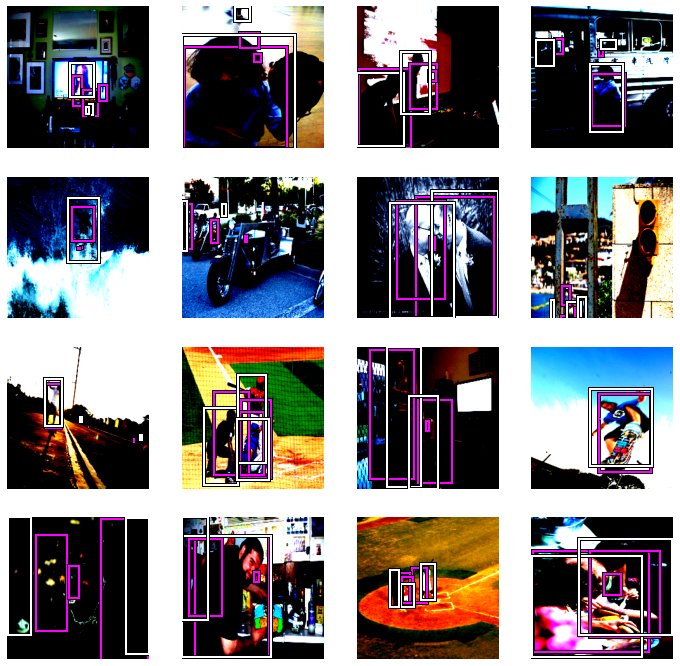

In [ ]:
from fastai.vision.all import *


### Params ###
im_size    = 224
batch_size = 64
path       = Path('/home/rory/data/coco2017')
valid_pct  = .15


### Data ###
df = pd.read_pickle(path/'20201020_coco_multiple_bboxes_df.pkl')
def equalize_row_counts(df, col):
    min_n = min(df[col].value_counts())
    vals = df['n_persons'].unique()
    return pd.concat([df[df[col]==v].sample(n=min_n) for v in vals])
def select_from_where_in(cols, df, where_col, in_vals, eq=False):
    df = df[cols]
    df = pd.concat([df[df[where_col]==v] for v in in_vals])
    if eq: df = equalize_row_counts(df, where_col)
    return df
cols = ['path','person_lbls','person_bboxes','n_persons']
df = select_from_where_in(cols, df, 'n_persons', [1,2,3], eq=True)
def get_cols(df, cols):
    """Expects: DataFrame df; str or list of strs cols. Returns: list or an lol."""
    def c2l(df, col): return L(ColReader(col)(df).to_list())
    if isinstance(cols, str): return c2l(df, cols)
    if len(cols)==1: return c2l(df, cols)
    if len(cols)>=2:
        r=L()
        for c in cols: r.append(c2l(df,c))
        return r
paths,bboxes,lbls = get_cols(df, ['path','person_bboxes','person_lbls'])
path2bbox = {p:b for p,b in zip(paths,bboxes)}
path2lbl  = {p:l for p,l in zip(paths,lbls)}
def get_bbox(p): return path2bbox[p]
def get_lbl(p):  return path2lbl[p]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(im_size, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
dls = db.dataloaders(paths) # dls.train.n = 15701


### Model ###
class custom_module(Module):
    
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))
body = create_body(resnet34, pretrained=True)
n_cls    = len(dls.vocab)
bb_acts  = 4*3
lbl_acts = n_cls+1
head = create_head(1024, bb_acts+lbl_acts, ps=0.5)
mod  = custom_module(body, head)


### Loss ###
def mse(f, bb, lbl): return MSELossFlat()(f[:,:bb_acts], bb)


### Training ###
learner = Learner(dls, mod, loss_func=mse)
lr_min, _ = learner.lr_find(); print("lr_min:", lr_min)
learner.fit_one_cycle(10, lr=lr_min) # 0.085162

def view_mbb_results(learner, n=16, nrows=4, ncols=4, offset=0):
    
    # get batch of ims & targs, get preds
    ims, targ_bbs, targ_lbls = learner.dls.one_batch()
    preds = learner.model(ims)
    pred_bbs, pred_lbls = preds[:,:bb_acts], preds[:,bb_acts:].argmax(dim=-1)
    decoded_ims = ims
    
    # show grid results
    for i,ctx in enumerate(get_grid(n, nrows, ncols)):
        idx = i+offset*n
        show_image(decoded_ims[idx], ctx=ctx)
        pred_bb = TensorBBox(pred_bbs[idx])
        targ_bb = TensorBBox(targ_bbs[idx])
        ((pred_bb+1)*224//2).show(ctx=ctx, color='magenta')
        ((targ_bb+1)*224//2).show(ctx=ctx); 
view_mbb_results(learner)

In [ ]:
# view results (contains commented out lines)
def view_mbb_results(learner, n=16, nrows=4, ncols=4, offset=0):
    # get batch
    ims, targ_bbs, targ_lbls = learner.dls.one_batch()
    # make preds
    preds = learner.model(ims)
    pred_bbs, pred_lbls = preds[:,:bb_acts], preds[:,bb_acts:].argmax(dim=-1)
    decoded_ims = ims
    # show grid results
    for i,ctx in enumerate(get_grid(n, nrows, ncols)):
        idx = i+offset*n
        # title
        pred_cls = dls.vocab[pred_lbls[idx].item()]
        targ_cls = dls.vocab[targ_lbls[idx].item()]
        icon = '✔️' if pred_cls==targ_cls else '✖️'
        title = f"{icon}  P {pred_cls} : A {targ_cls}"
        # im
        show_image(decoded_ims[idx], ctx=ctx), title=title)
        # bbs
        pred_bb = TensorBBox(pred_bbs[idx])
        targ_bb = TensorBBox(targ_bbs[idx])
        ((pred_bb+1)*224//2).show(ctx=ctx, color='magenta')
        ((targ_bb+1)*224//2).show(ctx=ctx); 